In [1]:
import sys
sys.path.insert(0, '../src')

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import numpy as np
import tensorflow as tf

import deepxde as dde
from spaces import FinitePowerSeries, FiniteChebyshev, GRF
from system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem
from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


## Problem

Define a 1D dynamic system $\frac{s(x)}{dx}=g(s(x), u(x), x)$

In [3]:
def ode_system(T):
    """ODE"""

    def g(s, u, x):
        # Antiderivative
        return u
        # Nonlinear ODE
        # return -s**2 + u
        # Gravity pendulum
        # k = 1
        # return [s[1], - k * np.sin(s[0]) + u]

    s0 = [0]
    # s0 = [0, 0]  # Gravity pendulum
    return ODESystem(g, s0, T)

Antiderivative: $\frac{s(x)}{dx}=u(x)$

In [4]:
problem = "ode"  # Antiderivative, Nonlinear ODE, Gravity pendulum
T = 1
system = ode_system(T)  # Antiderivative

## DeepONet Model

In [59]:
 # Hyperparameters
m = 100
num_train = 1000
num_test = 1000
lr = 0.001
epochs = 50000

# Network
nn = "opnn"
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 1 
net = dde.maps.OpNN(
    [m, 40, 40],
    [dim_x, 40, 40],
    activation,
    initializer,
    use_bias=True,
    stacked=False,
)

## Data generation

### Function space

In [60]:
space = GRF(1, length_scale=0.2, N=1000, interp="cubic")

In [61]:
X_train, y_train = system.gen_operator_data(space, m, num_train)
X_test, y_test = system.gen_operator_data(space, m, num_test)

Generating operator data...
'gen_operator_data' took 4.747789 s

Generating operator data...
'gen_operator_data' took 4.704735 s



In [62]:
X_test_trim = trim_to_65535(X_test)[0]
y_test_trim = trim_to_65535(y_test)[0]

data = dde.data.OpDataSet(X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim)

In [134]:
data.test_x[1].shape

(1000, 1)

In [64]:
data.test_y.shape

(1000, 1)

### Visualized training data

In [139]:
import matplotlib.pyplot as plt
import imageio
%matplotlib inline  

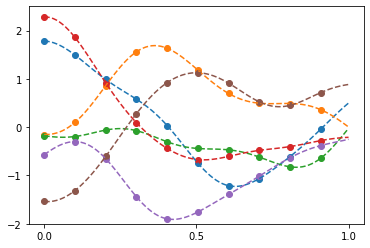

In [147]:
sensors = np.linspace(0, 1, num=m)[:, None]

plt.ylim([-2,2.5])
plt.yticks(np.linspace(-2,2,5))
plt.xlim([-0.05,1.05])
plt.xticks(np.linspace(0,1,3))

filenames = []
filename = f'start.png'
plt.savefig(filename)
filenames.append(filename)


for i in range(6):
    plt.plot(sensors, data.train_x[0][i,:], '--')
    #create file name and append it to a list
    filename = f'line{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)

    plt.scatter(sensors[np.arange(0,m,10)], data.train_x[0][i,np.arange(0,m,10)])
    #create file name and append it to a list
    filename = f'smaple{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)

# build gif
with imageio.get_writer('figs/grf.gif', mode='I', duration=0.4) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)

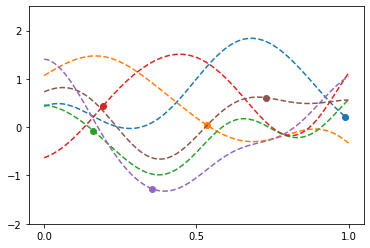

In [149]:
# The sampling functions are not G(u). It is just for visulization.
plt.ylim([-2,2.5])
plt.yticks(np.linspace(-2,2,5))
plt.xlim([-0.05,1.05])
plt.xticks(np.linspace(0,1,3))

filenames = []
filename = f'start.png'
plt.savefig(filename)
filenames.append(filename)

for i in range(10, 16):
    plt.plot(sensors, data.train_x[0][i,:], '--')
    #create file name and append it to a list
    filename = f'line{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)

    idx = np.random.randint(0, m)
    plt.scatter(sensors[idx], data.train_x[0][i,idx])
    #create file name and append it to a list
    filename = f'smaple{i}.png'
    filenames.append(filename)
    # save frame
    plt.savefig(filename)

# build gif
with imageio.get_writer('figs/grf_y.gif', mode='I', duration=0.4) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in set(filenames):
    os.remove(filename)


## Train DeepONet

In [65]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1000
)
losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])

Compiling model...
Building operator neural network...
'build' took 0.054768 s

'compile' took 0.201880 s



/home/shushu/anaconda3/envs/PINN/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/shushu/anaconda3/envs/PINN/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [1.32e-01]    [1.36e-01]    [1.35e-01]    
1000      [1.53e-04]    [3.91e-04]    [3.80e-04]    
INFO:tensorflow:model/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [6.79e-05]    [2.02e-04]    [1.98e-04]    
INFO:tensorflow:model/model.ckpt-2000 is not in all_model_checkpoint_paths. Manually adding it.
3000      [4.06e-05]    [1.54e-04]    [1.51e-04]    
INFO:tensorflow:model/model.ckpt-3000 is not in all_model_checkpoint_paths. Manually adding it.
4000      [2.75e-05]    [1.22e-04]    [1.19e-04]    
INFO:tensorflow:model/model.ckpt-4000 is not in all_model_checkpoint_paths. Manually adding it.
5000      [2.36e-05]    [1.11e-04]    [1.09e-04]    
INFO:tensorflow:model/model.ckpt-5000 is not in all_model_checkpoint_paths. Manually adding it.
6000      [2.80e-05]    [1.08e-04]    [1.05e-04]    
7000      [1.28e-05]    [8.72e-05]    [8.52e-05]   

Saving loss history to /home/shushu/Documents/PythonWorkspace/PINN/deeponet/notebook/loss.dat ...
Saving training data to /home/shushu/Documents/PythonWorkspace/PINN/deeponet/notebook/train.dat ...
Saving test data to /home/shushu/Documents/PythonWorkspace/PINN/deeponet/notebook/test.dat ...


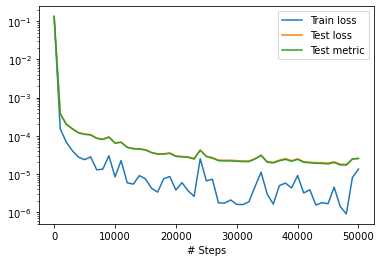

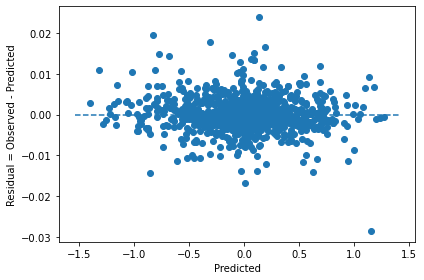

In [150]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Test trained model

In [151]:
model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)
safe_test(model, data, X_test, y_test)

Restoring model from model/model.ckpt-48000 ...

INFO:tensorflow:Restoring parameters from model/model.ckpt-48000
Test MSE: 0.17817938096235658
Test MSE w/o outliers: 0.17630642638585167



In [67]:
def test_u_ode(nn, system, T, m, model, data, u, fname, num=100):
    """Test ODE"""
    sensors = np.linspace(0, T, num=m)[:, None]
    sensor_values = u(sensors)
    x = np.linspace(0, T, num=num)[:, None]
    X_test = [np.tile(sensor_values.T, (num, 1)), x]
    y_test = system.eval_s_func(u, x)
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    np.save(fname, np.hstack((x, y_test, y_pred)))
    print("L2relative error:", dde.metrics.l2_relative_error(y_test, y_pred))

In [68]:
tests = [
    (lambda x: x, "x"),
    (lambda x: np.sin(np.pi * x), "sinx"),
    (lambda x: np.sin(2 * np.pi * x), "sin2x"),
    (lambda x: x * np.sin(2 * np.pi * x), "xsin2x"),
]
for u, fname in tests:
    test_u_ode(nn, system, T, m, model, data, u, fname)

L2relative error: 0.01283981387140869
L2relative error: 0.013864324412922827
L2relative error: 0.013653535852851654
L2relative error: 0.0279824322922351


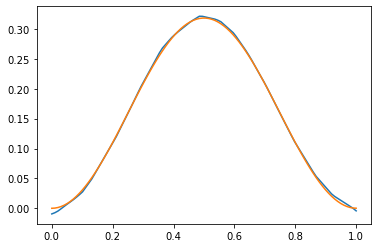

In [69]:
test_data = np.load('sin2x.npy')
x, y_test, y_pred = test_data[:,0], test_data[:,1],test_data[:,2]
plt.plot(x, y_pred)
plt.plot(x, y_test)

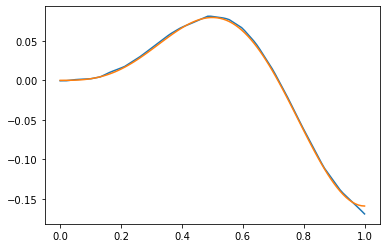

In [70]:
test_data = np.load('xsin2x.npy')
x, y_test, y_pred = test_data[:,0], test_data[:,1],test_data[:,2]
plt.plot(x, y_pred)
plt.plot(x, y_test)